In [1]:
import win32com.client

import email
import imaplib
import smtplib
import datetime
import email.mime.multipart
import base64
from time import sleep

import pandas as pd

In [2]:
outlook = win32com.client.Dispatch("Outlook.Application").GetNamespace("MAPI")

inbox_C4P_Cluster = outlook.Folders('Hathaichanok.T@chula.ac.th').Folders("Inbox").Folders("C4P Cluster")
inbox_Cluster_script = outlook.Folders('Hathaichanok.T@chula.ac.th').Folders("Inbox").Folders("Cluster-Script")
inbox_Cluster_Archive = outlook.Folders('Hathaichanok.T@chula.ac.th').Folders("Inbox").Folders("Cluster-Archive")


In [3]:
unread_messages = []

for message in inbox_C4P_Cluster.Items:
    if message.Unread == True:
        unread_messages.append(message)

for email in unread_messages:
    email.Move(inbox_Cluster_script)

In [4]:
messages = inbox_Cluster_script.Items
messages.Sort("[ReceivedTime]", True)
#message = messages.GetLast()

Subject_list = []
SentOn_list = []
EntryID_list = []
Body_list = []
for msg in messages:
    #print(msg)

    msg_Subject = getattr(msg, "Subject", "<UNKNOWN>")
    Subject_list.append(msg_Subject)
    
    msg_SentOn = getattr(msg, "SentOn", "<UNKNOWN>")
    SentOn_list.append(msg_SentOn)
    #print(msg_SentOn)

    msg_Body = getattr(msg, "Body", "<UNKNOWN>")
    Body_list.append(msg_Body)
#print(items)



In [6]:
df_msg = pd.DataFrame()
df_msg['Subject'] = Subject_list
df_msg['Body'] = Body_list
SentOn_ReFormat = [i.Format('%Y-%m-%d %H:%M:%S') for i in SentOn_list]
df_msg['SentOn'] = SentOn_ReFormat
df_msg['aDate'] = df_msg['SentOn'].apply(lambda i:i.split(' ')).apply(lambda i:i[0])
df_msg['aTime'] = df_msg['SentOn'].apply(lambda i:i.split(' ')).apply(lambda i:i[1])

df_msg['Node'] = df_msg['Subject'].apply(lambda i:i.split(' on')).apply(lambda i:i[1]).apply(lambda i:i.strip())
df_msg['Service'] = df_msg['Subject'].apply(lambda i:i.split(' on ')).apply(lambda i:i[0].split(' for ')).apply(lambda i:i[1]).apply(lambda i:i.strip())
df_msg['Status_str'] = df_msg['Body'].apply(lambda i:i.split(' status ')[1]).apply(lambda i:i.split(' and ')[0]).apply(lambda i:i.split(' ')[0])

Status_int = []
for i in df_msg['Status_str']:
    #print(i)
    if i.isdigit() == False:
        Status_int1 = 0
    else:
        Status_int1 = int(i)
    Status_int.append(Status_int1)

df_msg['Status_number_int'] = Status_int
df_msg['Status'] = df_msg['Body'].apply(lambda i:i.split(' status ')[1]).apply(lambda i:i.split(' and ')[0]).apply(lambda i:i.split(" ")[2])

In [7]:
df_msg.head()

,Subject,Body,SentOn,aDate,aTime,Node,Service,Status_str,Status_number_int,Status
0,monitor pending for ClusterMon-SMTP on a4pa2dr04,The monitor operation for ClusterMon-SMTP on ...,2024-09-18 09:02:15,2024-09-18,09:02:15,a4pa2dr04,ClusterMon-SMTP,193,193,(pending)
1,monitor pending for ClusterMon-SMTP on a4pa2dr04,The monitor operation for ClusterMon-SMTP on ...,2024-09-18 09:02:15,2024-09-18,09:02:15,a4pa2dr04,ClusterMon-SMTP,193,193,(pending)
2,monitor pending for ClusterMon-SMTP on a4pa2dr04,The monitor operation for ClusterMon-SMTP on ...,2024-09-18 09:02:15,2024-09-18,09:02:15,a4pa2dr04,ClusterMon-SMTP,193,193,(pending)
3,monitor pending for ClusterMon-SMTP on a4pa2dr04,The monitor operation for ClusterMon-SMTP on ...,2024-09-18 09:02:15,2024-09-18,09:02:15,a4pa2dr04,ClusterMon-SMTP,193,193,(pending)
4,monitor pending for ClusterMon-SMTP on a4pa1dc02,The monitor operation for ClusterMon-SMTP on ...,2024-09-18 09:02:02,2024-09-18,09:02:02,a4pa1dc02,ClusterMon-SMTP,193,193,(pending)


ติดต่อฐานข้อมูล

In [9]:
#pip install mysql-connector-python

In [28]:
import mysql.connector
import mysql

In [29]:
#ทำการเชื่อมต่อกับฐานข้อมูลง่าย ๆ แค่ใส่ Host / User / Password ให้ถูกต้อง

connection = mysql.connector.connect(
host="localhost",
user="root",
password="password"
)
print(connection)
server_cursor = connection.cursor()

In [30]:
#รันสร้าง Database  ได้เลย ถ้ามีอยู่แล้วไม่ต้องสร้าง
def create_db(connection,server_cursor,db_name):
    #create_db(connection,server_cursor,'db_name4')

    sql_create = "CREATE DATABASE {}".format(db_name)
    server_cursor.execute(sql_create)
    connection.commit()


In [13]:
#create_db(connection,server_cursor,'MailAlert')

In [31]:
#ทำการเชื่อมต่อกับฐานข้อมูลง่าย ๆ แค่ใส่ Host / User / Password / DB ให้ถูกต้อง
connection = mysql.connector.connect(
host="localhost",
user="root",
password="password",
database="MailAlert"
)
db_cursor = connection.cursor()

In [32]:
 #สร้าง table ถ้ามีอยู่แล้วไม่ต้องสร้าง
def create_table(connection, db_cursor, table_name): 
    #create_table(connection, db_cursor, 'table_name')

   
    db_cursor.execute('''DROP TABLE IF EXISTS {}'''.format(table_name))
    connection.commit()

    #สร้าง Table ลงไป ก็ใช้ Execute ได้เช่นกัน
    db_cursor.execute('''CREATE TABLE IF NOT EXISTS {}( \
        id INT NOT NULL AUTO_INCREMENT PRIMARY KEY, \
        Subject VARCHAR(255),\
        Body VARCHAR(255),\
        SentOn datetime,\
        aDate date,\
        aTime time,\
        Node VARCHAR(255),\
        Service VARCHAR(255),\
        Status_number VARCHAR(255),\
        Status_number_int int,\
        Status VARCHAR(255))'''.format(table_name))
    connection.commit()


In [16]:
#create_table(connection, db_cursor, 'alertinfo')

เพิ่ม Record ลงในฐานข้อมูล

In [33]:
def insert_data(connection, db_cursor, df_msg,n):   
    #สร้าง String ไว้รอใส่คำสั่งได้เลย
    sql_command = "INSERT INTO alertinfo (\
                    id,Subject, Body, SentOn, adate, atime, Node, Service, \
                    Status_number, Status_number_int, Status) \
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"

    #Value ที่ต้องการใส่ใน Command ทำไว้ในรูปแบบ Tuple ไว้ทำการ map กับคำสั่งด้านบนในตรง VALUES
    #val = (None,"Hi3", "Hi", "2024-08-27 09:05:18", "Hi", "Hi", "Hi", "8", "Hi")
    sj = df_msg['Subject'][n]
    bd = df_msg['Body'][n]
    so = df_msg['SentOn'][n]
    ad = df_msg['aDate'][n]
    at = df_msg['aTime'][n]
    nd = df_msg['Node'][n]
    sv = df_msg['Service'][n]
    ss = df_msg['Status_str'][n]
    si = df_msg['Status_number_int'][n].item()
    st = df_msg['Status'][n]
    val = None, sj, bd, so, ad, at, nd, sv, ss, si, st

    #สั่งให้คำสั่งทำงานได้เลย
    db_cursor.execute(sql_command, val)
    connection.commit()

In [34]:

for index , row in df_msg.iterrows():
    #print(index)
    insert_data(connection, db_cursor, df_msg,index)

connection.commit()

In [35]:
connection.commit()

#แสดงว่ามีกี่แถวที่ทำงานสำเร็จ
print(db_cursor.rowcount, "Succeed !")

1 Succeed !


In [ ]:
#move mail to archive
unread_messages2 = []

for message in inbox_Cluster_script.Items:
    if message.Unread == True:
        unread_messages2.append(message)

for email in unread_messages2:
    email.Move(inbox_Cluster_Archive)

#Plot

In [63]:
#pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

a4pa2dr04
a4pa1dc02
fepa2dr04
fepa1dc02
nfsa2dr04
nfsa1dc02
s4pa1dc02
s4pa2dr04


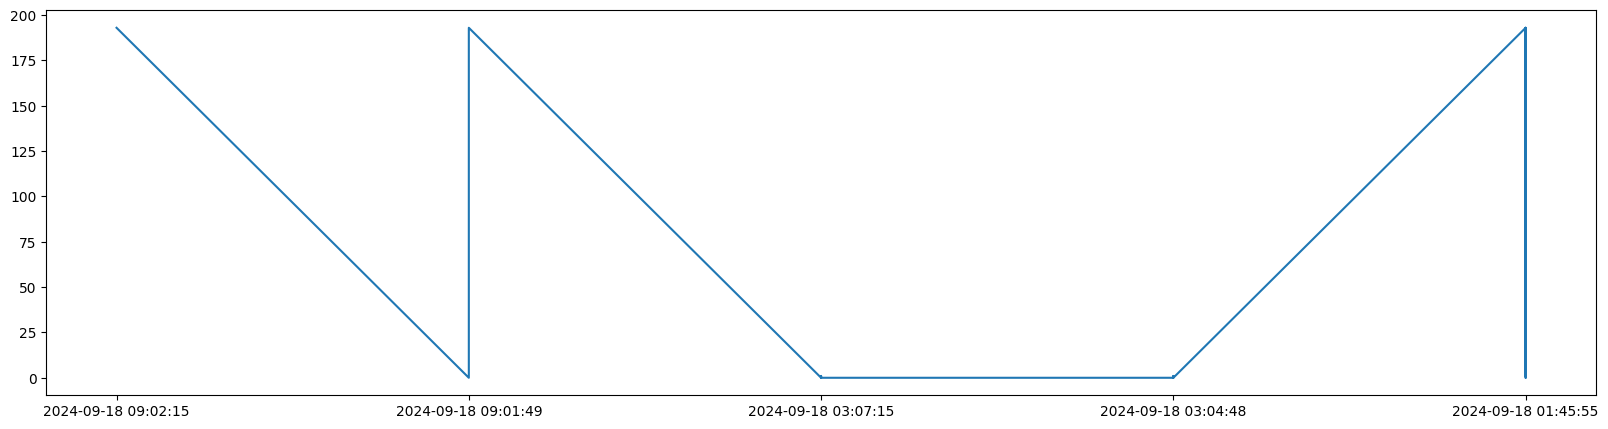

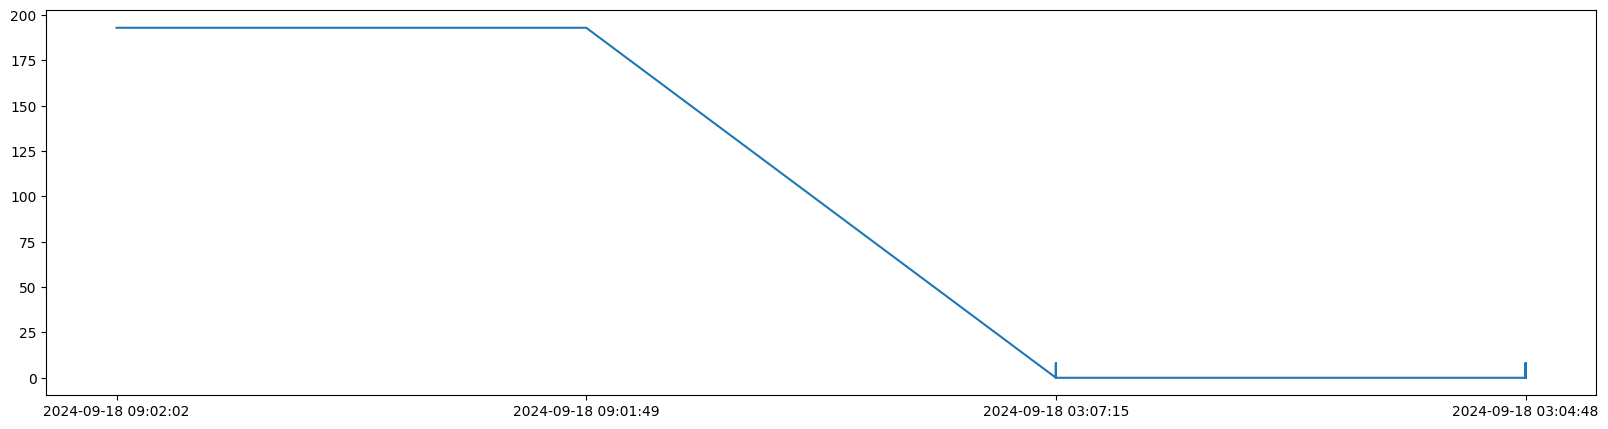

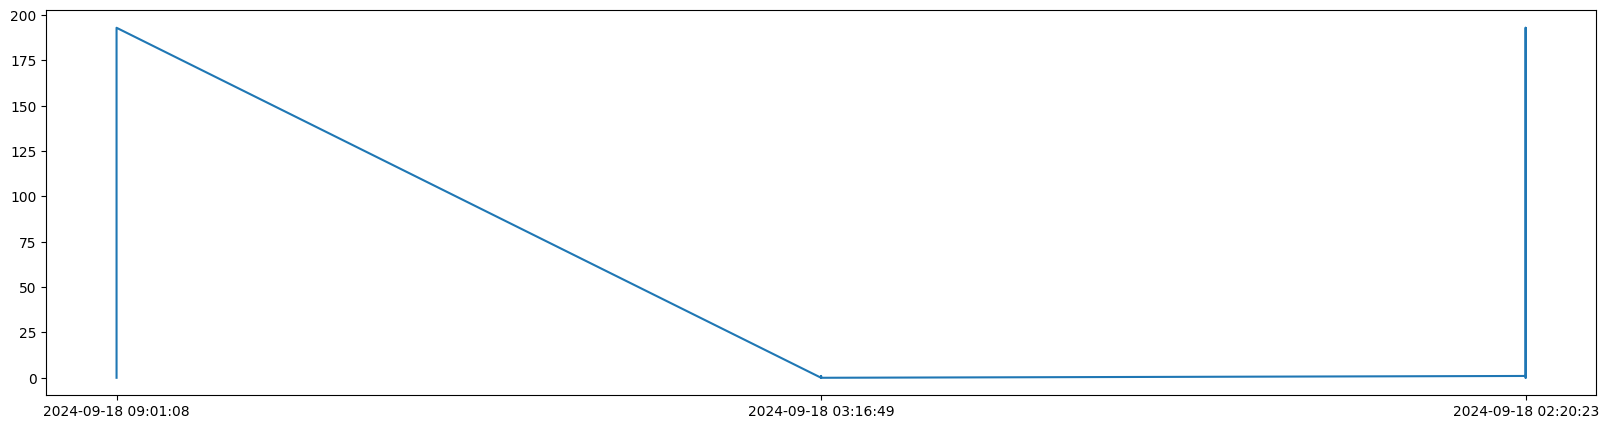

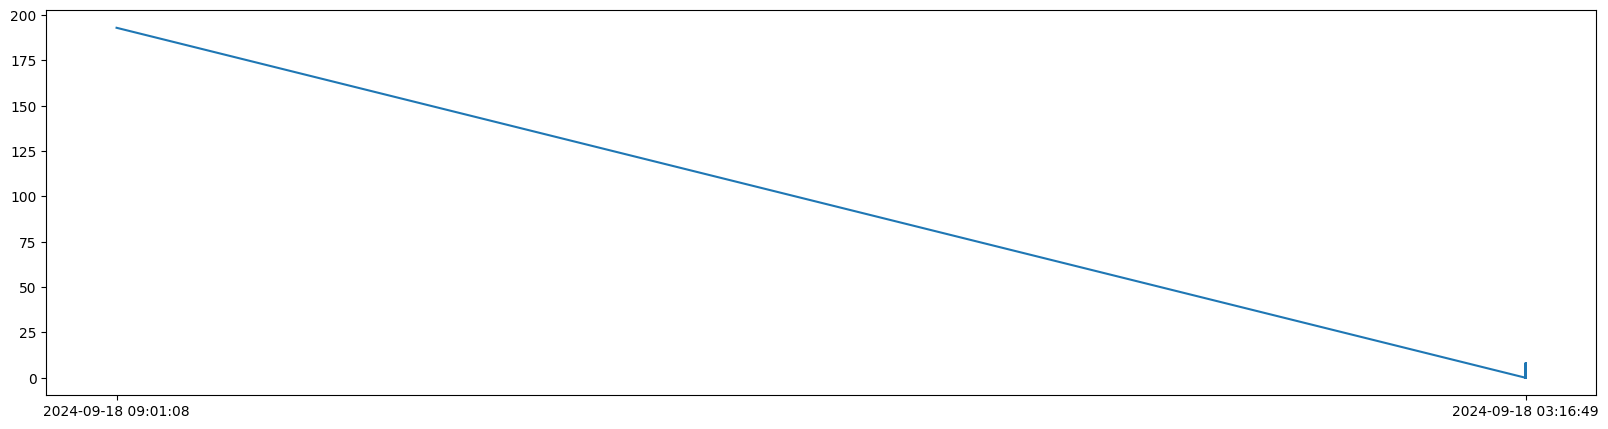

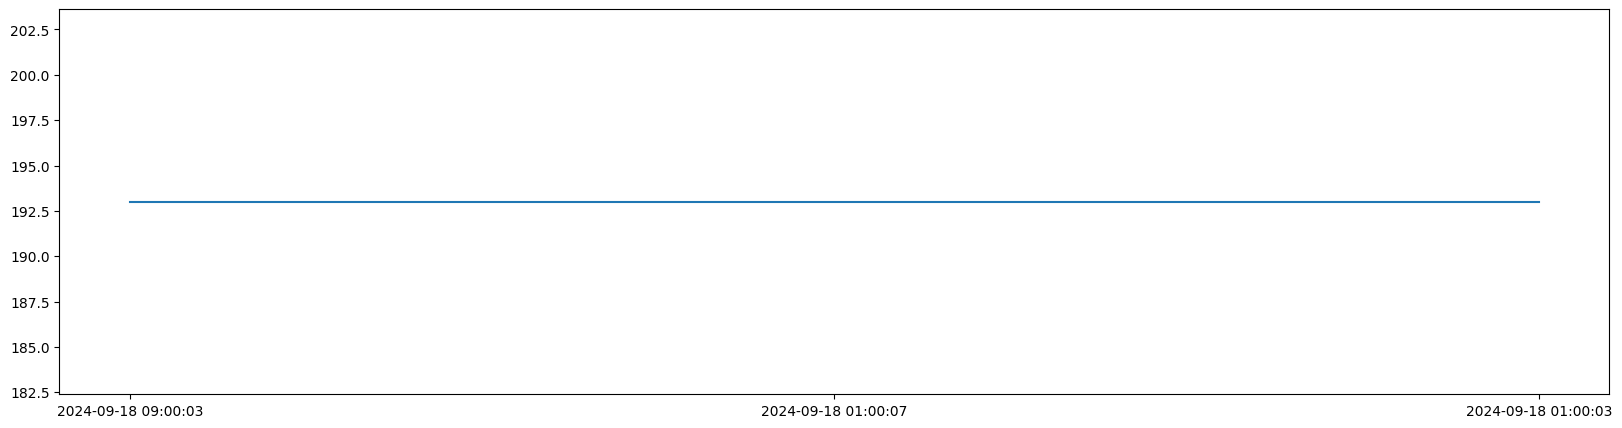

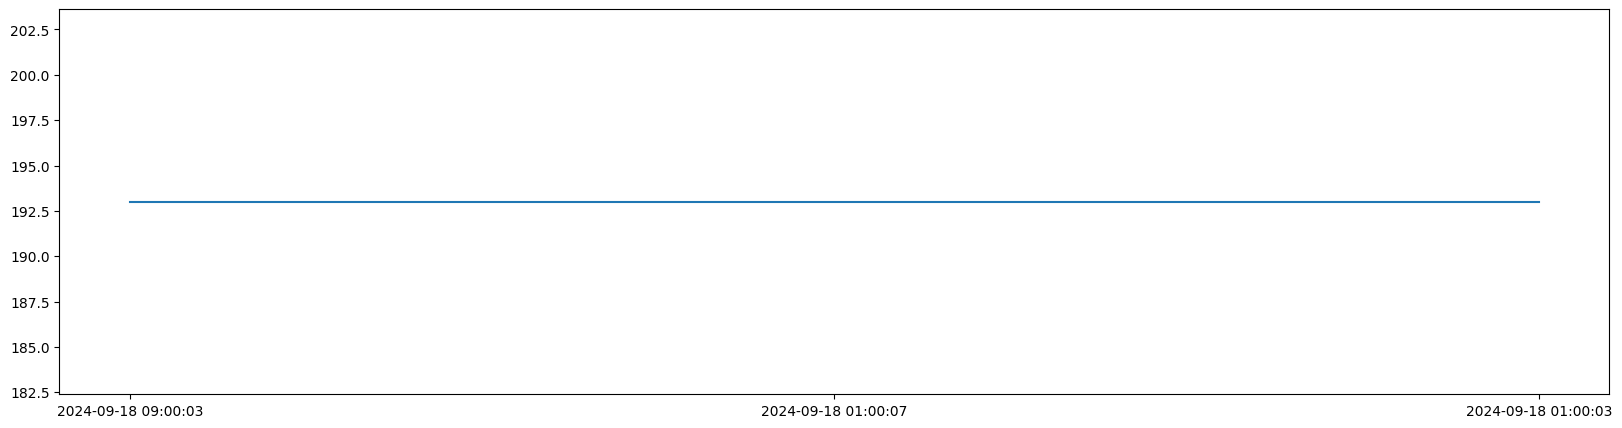

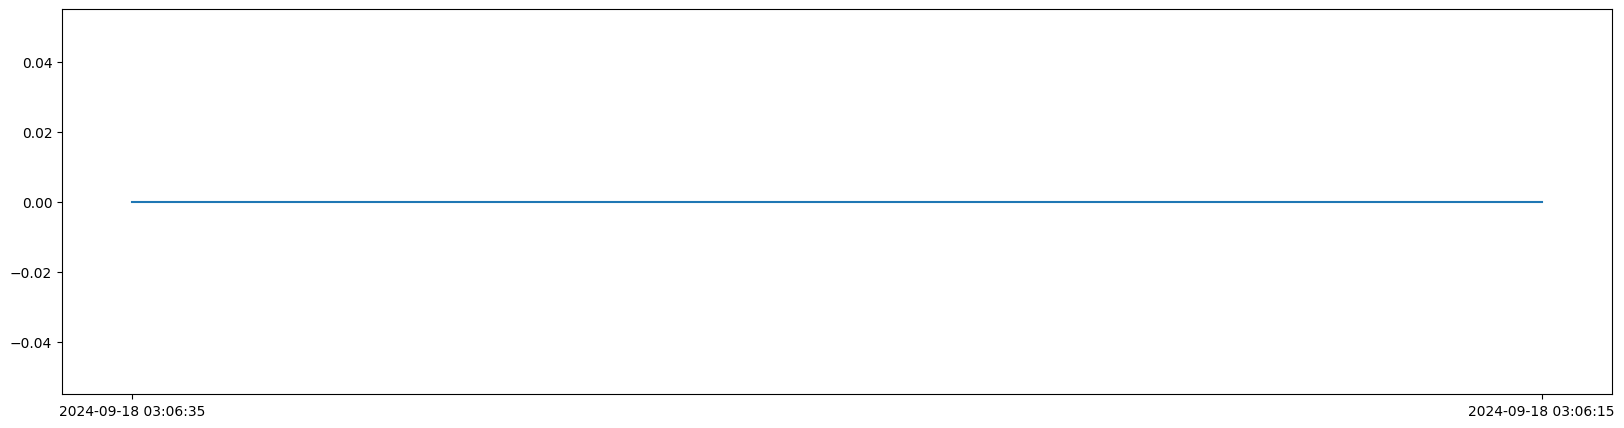

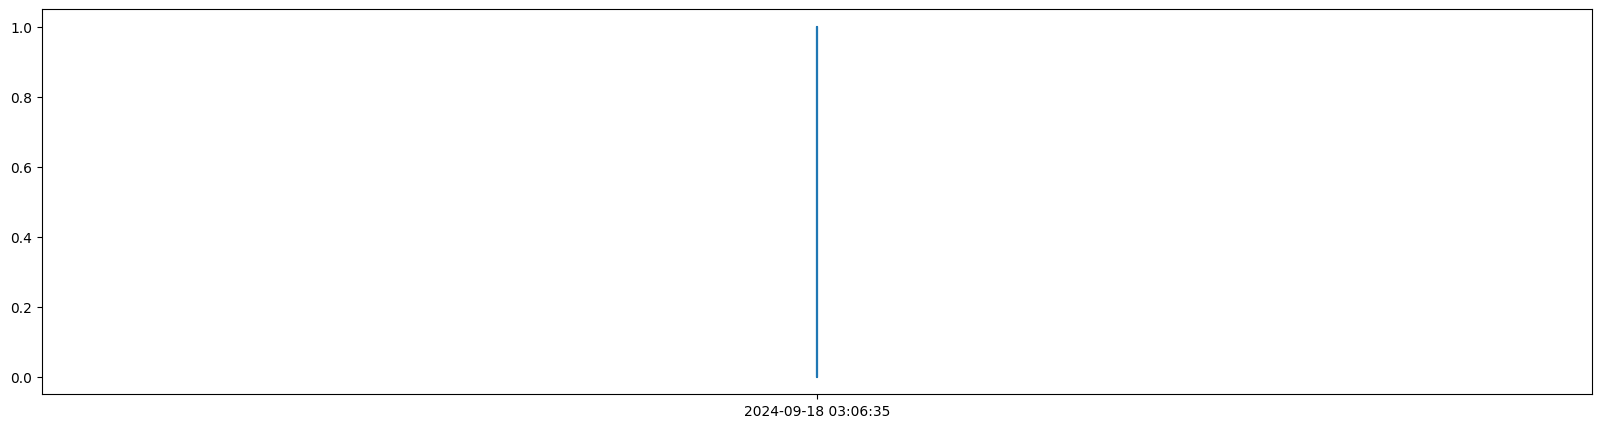

In [77]:
fig_col = ['SentOn','aDate','aTime','Node','Status_number_int']
df_msg2 = df_msg.copy()
Node_unique = df_msg2['Node'].unique()
Node_len = len(Node_unique)

for i in Node_unique:
    print(i)
    fig_node = df_msg2[fig_col][df_msg2['Node'] == i]

    plt.figure(figsize=(20,5))
    fig_node.sort_values('SentOn', ascending=False)
    plt.plot(fig_node['SentOn'], fig_node['Status_number_int'])

# https://gist.github.com/briglx/3d5aa90144a4696be61b3991aa339cc5